# Event detection

When integrating systems of ODEs, the need often arises to detect the occurrence of specific
conditions (or *events*) in the state of the system. Many real systems, for instance, are described by equations
that change discontinuously in response to particular conditions
(e.g., a spacecraft entering the cone of shadow of a planet,
or a thermostat switching on once the temperature reaches a certain level). In other situations,
detection of specific system states may suffice (e.g., in the computation of
[Poincaré sections](https://en.wikipedia.org/wiki/Poincar%C3%A9_map)).

An event in a system of ODEs can be defined by an *event equation* of the form 

$$
g\left( t, \boldsymbol{x} \left( t \right) \right) = 0,
$$

where, as usual, $t$ is the independent variable (time) and $\boldsymbol{x} \left( t \right)$ the state vector of the system.
As a concrete example, the collision between two spheres of radius 1 moving in a three-dimensional space can be described
by the event equation

$$
\left( x_1 - x_0 \right)^2 + \left( y_1 - y_0 \right)^2 + \left( z_1 - z_0 \right)^2 - 4 = 0,
$$

where $\left( x_0, y_0, z_0 \right)$ and $\left( x_1, y_1, z_1 \right)$ are the Cartesian coordinates
of the spheres' centres.

heyoka.py features a flexible and accurate event detection framework in which the [expression system](<./The expression system.ipynb>)
can be used to formulate arbitrary event equations. The event equations are then added to the ODE system and
integrated together with the other equations, so that, at every timestep, a Taylor series expansion of the event equations
in powers of time is available. Polynomial root finding techniques are then employed
on the Taylor series of the event equations to accurately locate the time of occurrence of an event within the timestep.

Like many other ODE integration libraries, heyoka.py makes a fundamental distinction between two types of events, *terminal* and *non-terminal*.
We will begin with non-terminal events, as they are conceptually simpler.

## Non-terminal events

Non-terminal events are events that do not modify the state of an ODE system. That is, the occurrence of a non-terminal event does not
change the system's dynamics and it does not alter the state vector of the system. A typical use of non-terminal events is to detect and log
when the system reaches a particular state of interest (e.g., flagging close encounters between celestial bodies, detecting when
a velocity or coordinate is zero, etc.).

As an initial example, we will turn to our good ole friend, the simple pendulum:

$$
\begin{cases}
x^\prime = v \\
v^\prime = -9.8 \sin x
\end{cases}.
$$

Our goal will be to detect when the bob reaches the point of maximum amplitude, which corresponds to the angular velocity
$v$ going to zero. In other words, out (very simple) event equation is

$$
v = 0.
$$

We begin, as usual, with the definition of the symbolic variables:

In [1]:
import heyoka as hy

x, v = hy.make_vars("x", "v")

Next, we create a list into which we will log the times at which $v = 0$:

In [2]:
zero_vel_times = []

We can now proceed to create a non-terminal event:

In [3]:
# Define a callback for the event.
def cb(ta, time, d_sgn):
    # Compute the state of the system when the
    # event triggered and print the value of x.
    ta.update_d_output(time)
    print("Value of x when v is zero: {}".format(ta.d_output[0]))
    
    # Add the event time to zero_vel_times.
    zero_vel_times.append(time)

ev = hy.nt_event(
        # The left-hand side of the event equation
        v,
        # The callback.
        callback = cb)

Non-terminal events are represented in heyoka.py by the ``nt_event`` class. The first mandatory argument for the construction of a non-terminal event is the left-hand
side of the event equation, which in this case is simply $v$.
The second mandatory construction argument is a callback function that will be invoked when the event is detected.
The callback function can be a lambda, a regular function, or a function object - the only requirement is that the
callback is a callable object. The callback will be invoked with a reference to the integrator object as first argument, 
the absolute time at which the event was detected (i.e., the trigger time) as second argument, and the sign of the derivative
of the event equation at the trigger time as third argument (-1 for negative derivative, 1 for positive derivative and 0 for
zero derivative).

```{note}

Callbacks are always {func}`deep-copied <copy.deepcopy>` when an event object is created or copied. This behaviour
is meant to help preventing data races in stateful callbacks during multi-threaded {ref}`ensemble propagations<ensemble_prop>`.
You can disable the deep-copying behaviour by providing a custom implementation of the ``__deepcopy__`` method
for the callback, as explained in the documentation of the {mod}`copy` module.
```

Because non-terminal event detection is performed at the end of an integration step,
when the callback is invoked the state and time of the integrator object are those *at the end* of the integration
step in which the event was detected. This bears repeating, as it is often a source of confusion
and bugs when implementing callbacks for non-terminal events:

```{warning}

When the callback of a non-terminal event is invoked, the state and time
of the integrator object are those *at the end* of the integration
step in which the event was detected.
```

When integrating an ODE system with events, the ``taylor_adaptive``
class ensures that the Taylor coefficients are always kept up to date (as explained in the tutorial about
[dense output](<./Dense output.ipynb>)), and thus in the callback function it is always possible to use the ``update_d_output()``
function to compute the dense output at any time within the last timestep that was taken (including the event
trigger time).

In this example, we perform two actions in the callback ``cb``:

- first, we compute the dense output at the event trigger time and print
  the value of the ``x`` coordinate,
- second, we append to ``zero_vel_times`` the trigger time.

We are now ready to create our first event-detecting integrator:

In [4]:
ta = hy.taylor_adaptive(
    # Definition of the ODE system:
    # x' = v
    # v' = -9.8 * sin(x)
    ((x, v), (v, -9.8 * hy.sin(x))),
    # Initial conditions
    # for x and v.
    [-0.05, 0.],
    # Non-terminal events.
    nt_events = [ev])

The list of non-terminal events is passed to the constructor of the
integrator via the ``nt_events`` keyword argument. Note how we
set up the initial conditions so that the bob is at rest at an
angle of amplitude $0.05$.

Let us now integrate for a few time units and plot the evolution of the system
together with the times at which the event triggers:

Value of x when v is zero: -0.05
Value of x when v is zero: 0.049999999999999996
Value of x when v is zero: -0.05
Value of x when v is zero: 0.05
Value of x when v is zero: -0.049999999999999996


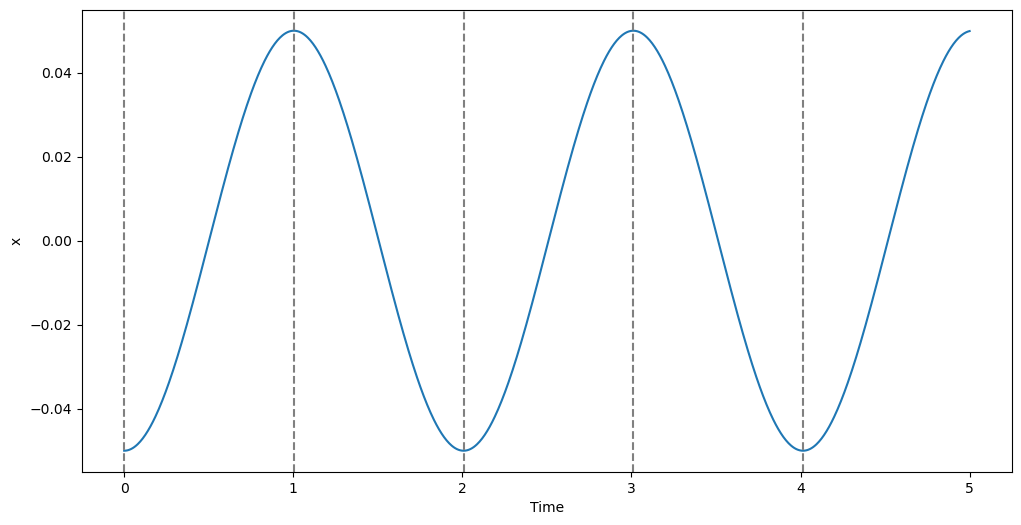

In [5]:
import numpy as np
from matplotlib.pylab import plt

# Construct a time grid from t=0 to t=5.
t_grid = np.linspace(0, 5, 1000)

# Propagate over the time grid.
x_hist = ta.propagate_grid(t_grid)[4][:,0]

# Display the time evolution for the x variable.
fig = plt.figure(figsize=(12, 6))
plt.plot(t_grid, x_hist)
plt.xlabel("Time")
plt.ylabel("x")

# Put vertical lines in correspondence of
# the detected events.
for ev_time in zero_vel_times:
    plt.axvline(x = ev_time, linestyle='--', color='gray')

As expected, $v$ is zero at the points of maximum amplitude for the angle,
and in these points the absolute value the $x$ angle corresponds to the
initial amplitude of $0.05$.

Let us now print the event times:

In [6]:
print(zero_vel_times)

[0.0, 1.003701787940065, 2.00740357588013, 3.011105363820195, 4.01480715176026]


We can see how the the initial condition $v_0 = 0$ immediately
and correctly triggers an event at $t = 0$. Physically, we know that the time
interval between the events must be half the period $T$ of the pendulum,
which can be computed exactly via elliptic functions. With the specific
initial conditions of this example, $T = 2.0074035758801299\ldots$, and
we can see from the event times printed to screen
how the event detection system was accurate to machine precision.

### Event direction

By default, heyoka.py will detect all zeroes of the event equations regardless
of the *direction* of the zero crossing (i.e., the value of the time derivative
of the event equation at the zero). However, it is sometimes useful to trigger the detection
of an event only if its direction is positive or negative. Event direction is represented
in heyoka.py by the ``event_direction`` enum, whose values can be

- ``event_direction.any`` (the default),
- ``event_direction.positive`` (derivative > 0),
- ``event_direction.negative`` (derivative < 0).

Event direction can be specified upon construction:

In [7]:
# Redefine ev to detect only events
# in the positive direction.
ev = hy.nt_event(
        v, callback = lambda ta, time, d_sgn: zero_vel_times.append(time),
        # Specify the direction.
        direction = hy.event_direction.positive)

# Reset zero_vel_times and the integrator.
zero_vel_times.clear()
ta = hy.taylor_adaptive(((x, v), (v, -9.8 * hy.sin(x))), [-0.05, 0.], nt_events = [ev])

In this specific case, constraining the event direction to be positive is equivalent
to detecting $v = 0$ only when the pendulum reaches the maximum amplitude on the left.
Let us take a look at the plot:

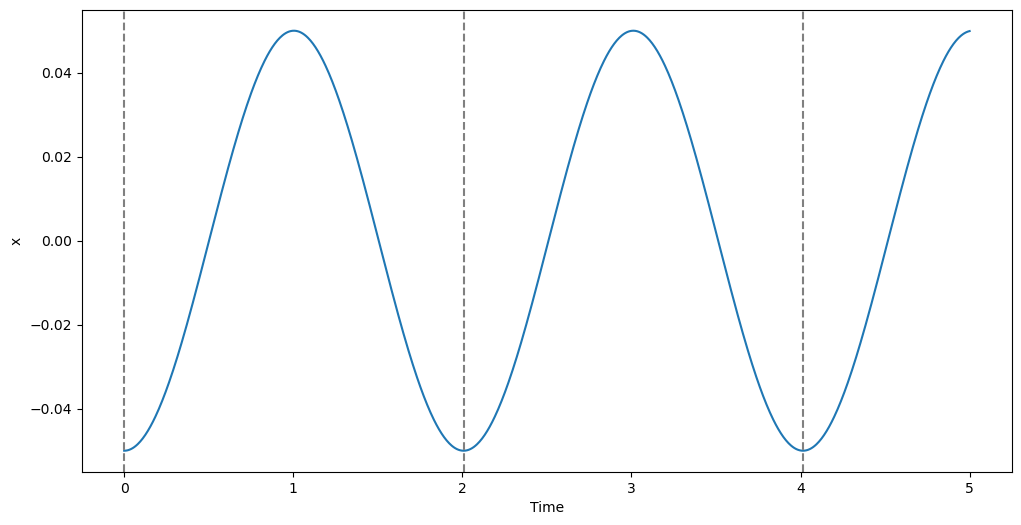

In [8]:
# Propagate over the time grid.
x_hist = ta.propagate_grid(t_grid)[4][:,0]

# Display the time evolution for the x variable.
fig = plt.figure(figsize=(12, 6))
plt.plot(t_grid, x_hist)
plt.xlabel("Time")
plt.ylabel("x")

# Put vertical lines in correspondence of
# the detected events.
for ev_time in zero_vel_times:
    plt.axvline(x = ev_time, linestyle='--', color='gray')

Indeed, the event now triggers only 3 times (instead of 5). Let's take a loot at the event times:

In [9]:
print(zero_vel_times)

[0.0, 2.00740357588013, 4.01480715176026]


The times confirm that the event is detected only when $v$ switches from negative to positive, i.e.,
at $t=0$, $t=T$ and $t=2T$.

### Multiple events

When multiple events trigger within the same timestep (or if the same event triggers
multiple times), heyoka.py will process the events in chronological order
(or reverse chronological order when integrating backwards in time).

Let us demonstrate this with another example with the simple pendulum.
We will now aim to detect two events defined by the equations:

$$
\begin{cases}
v = 0 \\
v^2 - 10^{-12} = 0
\end{cases}.
$$

In other words, we are looking to determine the time of maximum amplitude ($v = 0$) and
the time at which the absolute value of the angular velocity is small but not zero. Because
of the closeness of these events, we can expect both events to be detected during the same timestep,
with the second event triggering twice.

Let's begin by defining the two events:

In [10]:
# Define two close non-terminal events.
ev0 = hy.nt_event(v, lambda ta, time, d_sgn: print("Event 0 triggering at t={}".format(time)))
ev1 = hy.nt_event(v * v - 1e-12,  lambda ta, time, d_sgn: print("Event 1 triggering at t={}".format(time)))

This time the events' callbacks just print the event time to screen, without
modifying the ``zero_vel_times`` list.

We can then reset the integrator, propagate for a few time units and check the screen output:

In [11]:
# Reset the integrator.
ta = hy.taylor_adaptive(((x, v), (v, -9.8 * hy.sin(x))), [-0.05, 0.], nt_events = [ev0, ev1])

# Propagate for a few time units.
ta.propagate_until(5.)

Event 0 triggering at t=0.0
Event 1 triggering at t=2.0416669147618175e-06
Event 1 triggering at t=1.0036997462725616
Event 0 triggering at t=1.003701787940065
Event 1 triggering at t=1.0037038296081024
Event 1 triggering at t=2.0074015342133102
Event 0 triggering at t=2.00740357588013
Event 1 triggering at t=2.0074056175472714
Event 1 triggering at t=3.0111033221532955
Event 0 triggering at t=3.011105363820195
Event 1 triggering at t=3.0111074054870994
Event 1 triggering at t=4.0148051100933335
Event 0 triggering at t=4.01480715176026
Event 1 triggering at t=4.014809193427186


(<taylor_outcome.time_limit: -4294967299>,
 0.17033435611316083,
 0.17602774916423602,
 29,
 None)

Note how the events are indeed processed in chronological order, and how the event detection system is able to
successfully recognize the second event triggering twice in close succession.

## Terminal events

The fundamental characteristic of terminal events is that, in contrast to non-terminal events,
they alter the dynamics and/or the state of the system. A typical example of a terminal event is the
[elastic collision](https://en.wikipedia.org/wiki/Elastic_collision) of
two rigid bodies, which instantaneously and discontinuously changes the bodies' velocity vectors.
Another example is the switching on of a spacecraft engine, which alters the differential
equations governing the dynamics of the spacecraft.

Terminal events are represented in heyoka.py by the ``t_event`` class. Similarly to
the ``nt_event`` class, the construction of a ``t_event`` requires
at the very least the expression corresponding to the left-hand side of the event equation.
A number of additional optional keyword arguments can be passed to customise the behaviour
of a terminal event:

- ``callback``: a callback function that will be called when the event triggers. Note that,
  for terminal events, the presence of a callback is optional (whereas it is mandatory for
  non-terminal events). Like for non-terminal events, the callback of a terminal event
  (if present) is deep-copied into the event object during construction;
- ``cooldown``: a floating-point value representing the cooldown time for the terminal event
  (see below for an explanation);
- ``direction``: a value of the ``event_direction`` enum which, like for non-terminal
  events, can be used to specify that the event should be detected only for a specific direction
  of the zero crossing.

It is important to understand how heyoka.py reacts to terminal events. At every integration timestep, heyoka.py
performs event detection for both terminal and non-terminal events. If one or more terminal events
are detected, heyoka.py will sort the detected terminal events by time and will select the first
terminal event triggering in chronological order (or reverse chronological order when integrating
backwards in time). All the other terminal events and all the non-terminal events triggering *after*
the first terminal event are discarded. heyoka.py then propagates the state of the system up to the
trigger time of the first terminal event, executes the callbacks of the surviving non-terminal events
in chronological order and finally executes the callback of the first terminal event (if provided).

In order to illustrate the use of terminal events, we will consider a damped pendulum with a small twist:
the friction coefficient $\alpha$ switches discontinuously between 1 and 0 every time the angular
velocity $v$ is zero. The ODE system reads:

$$
\begin{cases}
x^\prime = v \\
v^\prime = - 9.8\sin x - \alpha v
\end{cases},
$$

and the terminal event equation is, again, simply $v = 0$.

Let us begin with the definition of the terminal event:

In [12]:
# Clear up zero_vel_times.
zero_vel_times.clear()

# Callback for the terminal event.
def t_cb(ta, mr, d_sgn):
    # NOTE: the value of the drag coefficient
    # is stored as the first (and only) runtime parameter
    # of the integrator.
    if ta.pars[0] == 0:
        ta.pars[0] = 1
    else:
        ta.pars[0] = 0

    # Append the event time to zero_vel_times.
    zero_vel_times.append(ta.time)

    # Do not stop the integration.
    return True

# Define a terminal event that turns air drag on/off
# whenever the velocity goes to zero.
t_ev = hy.t_event(
        # The event equation.
        v,
        # The callback.
        callback = t_cb)

Like in the case of non-terminal events, we specified as first construction argument
the event equation. As second argument we passed a callback function that will be invoked
when the event triggers.

As you can see from the code snippet, the callback signature for terminal events
differs from the signature non-terminal callbacks. Specifically:

- the event trigger time is not passed to the callback. This is not necessary
  because, when a terminal event triggers, the state of the integrator is propagated
  up to the event, and thus the trigger time is the current integrator time
  (which can be fetched via ``ta.time``);
- there is an additional boolean function argument, here called ``mr``. We will be ignoring
  this extra argument for the moment, its meaning will be clarified in the
  cooldown section below;
- whereas non-terminal event callbacks do not return anything, terminal event callbacks
  are required to return ``True`` or ``False``. If the callback returns ``False`` the integration
  will always be stopped after the execution of the callback. Otherwise, when using the
  ``propagate_*()`` family of functions, the integration will resume after the execution
  of the callback.

Note that, for the purpose of stopping the integration, an event *without* a callback is considered
equivalent to an event whose callback returns ``False``.
We thus refer to terminal events without a callback or whose callback returns ``False``
as *stopping* terminal events, because their occurrence will prevent the integrator from continuing
without user intervention.

Like for non-terminal events, the last callback argument is the sign of the time derivative
of the event equation at the event trigger time.

In this example, within the callback code we alter the value of the drag coefficient $\alpha$
(which is stored within the runtime parameters of the integrator): if $\alpha$
is currently 0, we set it to 1, otherwise we set it to 0.

Let us proceed to the construction of the integrator:

In [13]:
# Construct the damped pendulum integrator.
ta = hy.taylor_adaptive([(x, v),
                        # NOTE: alpha is represented as
                        # the first (and only) runtime
                        # parameter: par[0].
                        (v, -9.8 * hy.sin(x) - hy.par[0] * v)],
                        [0.05, 0.025],
                        # The list of terminal events.
                        t_events = [t_ev])

Similarly to the non-terminal events case, the list of terminal events
is specified when constructing an integrator via the ``t_events`` keyword argument.

If a terminal event triggers within the single-step functions (``step()`` and ``step_backward()``),
the outcome of the integration will contain the index of the event that triggered. Let us see a simple example:

In [14]:
# Propagate step-by-step until the event triggers.
oc, h = ta.step()
while oc == hy.taylor_outcome.success:
    oc, h = ta.step()

# Print the outcome to screen.
print("Event index: {}".format(int(oc)))

Event index: 0


The screen output confirms that the first (and only) event triggered. For stopping terminal events,
the numerical value of the outcome is the opposite of the event index minus one.

Because here we used the single step
function, even if the event's callback returned ``True`` the integration was stopped in correspondence of the
event. Let us now use the ``propagate_grid()`` function instead, so that the integration resumes after the
execution of the callback:

Final time: 10.0


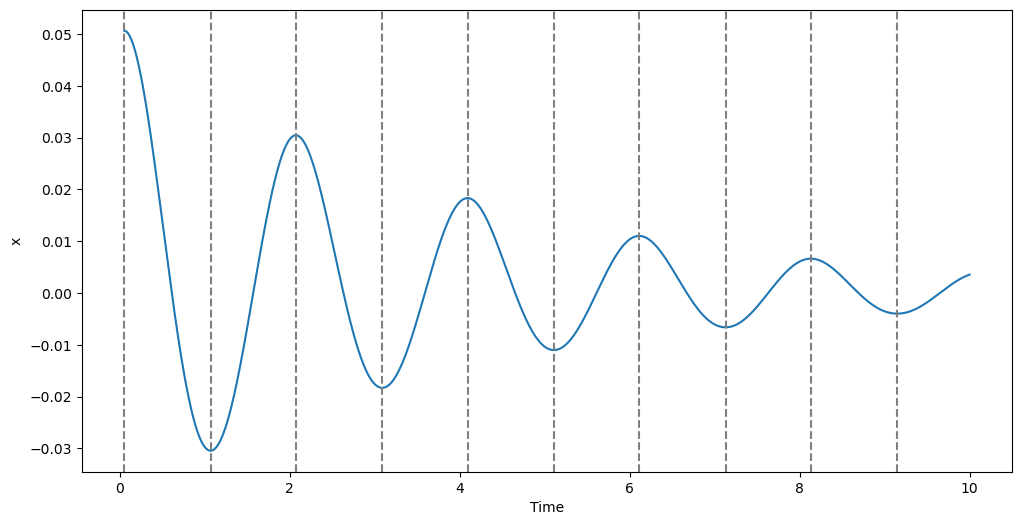

In [15]:
# Construct a time grid from the current time to t=10.
t_grid = np.linspace(ta.time, 10, 1000)

# Propagate over the time grid.
x_hist = ta.propagate_grid(t_grid)[4][:,0]

# Display the time evolution for the x variable.
fig = plt.figure(figsize=(12, 6))
plt.plot(t_grid, x_hist)
plt.xlabel("Time")
plt.ylabel("x")

# Put vertical lines in correspondence of
# the detected events.
for ev_time in zero_vel_times:
    plt.axvline(x = ev_time, linestyle='--', color='gray')

print("Final time: {}".format(ta.time))

The screen output confirms that indeed the integration continued up to the final time $t = 10$.

The plot shows how the event correctly triggered at $v=0$ and how, in the time intervals in which $\alpha = 1$, the motion of the pendulum was damped by the air drag.

### Cooldown

One notable complication when restarting an integration that was stopped in correspondence of a terminal event
is the risk of immediately re-triggering the same event, which would lead to an endless loop without any progress
being made in the integration.

In order to avoid this issue, whenever a terminal event occurs the event enters
a *cooldown* period. Within the cooldown period, occurrences of the same event are ignored by the event detection
system.

The length of the cooldown period is, by default, automatically deduced by heyoka.py, following a heuristic
that takes into account:

* the error tolerance of the integrator,
* the derivative of the event equation at the trigger time.

The heuristic works best under the assumption that the event equation does not change (much) after the
execution of the event's callback. If, for any reason, the automatic deduction heuristic is
to be avoided, it is possible to set a custom value for the cooldown.
A custom cooldown period can be selected when constructing
a terminal event via the ``cooldown`` keyword argument.

When a terminal event triggers and enters the cooldown period, the event detection system will also try to detect
the occurrence of multiple roots of the event equation within the cooldown period. If such multiple roots are detected,
then the ``mr`` boolean parameter in the terminal event callback will be set to ``True``, so that the user
has the possibility to handle such occurrence. Note that an ``mr`` value of ``False`` in the callback does not imply
that multiple roots do not exist, just that they were not detected.

Note that manually modifying the integrator's time or state does **not** automatically reset the cooldown values
for terminal events. This could in principle lead to missing terminal events when the integration restarts.
For this reason, a method called ``reset_cooldowns()`` is available to clear the cooldown timers of
all terminal events.

## Limitations and caveats

### Badly-conditioned event equations

Because heyoka.py's event detection system is based on polynomial root finding techniques, it will experience
issues when the Taylor series of the event equations have roots of multiplicity greater than 1. This is usually
not a problem in practice, unless the event equations are written in such a way to always generate polynomials
with multiple roots.

For instance, an event equation such as

$$
\left[ g\left( t, \boldsymbol{x} \left( t \right) \right) \right]^2 = 0
$$

will be troublesome, because both the event equation *and* its time derivative will be zero
when the event triggers. This will translate to a Taylor series with a double root in correspondence
of the event trigger time, which will lead to a breakdown of the root finding algorithm.
This, at best, will result in reduced performance and, at worst, in missing events altogether.
Additionally, in case of terminal events the automatically-deduced cooldown value in correspondence of
a double root will tend to infinity.

As a general rule, users should then avoid defining event equations in which the event trigger times
are stationary points.

Note that missed events due to badly-conditioned polynomials will likely be flagged by heyoka's logging system.

### Event equations and timestepping

As explained earlier, the differential equations of the events are added to the ODE system and
integrated together with the original equations. Because of this, event equations influence the
selection of the adaptive timestep, even if no event is ever detected throughout the integration.

For instance, the absolute value of the event equation at the beginning of the timestep is taken
into account for the determination of the timestep size in relative error control mode. Thus, if
the typical magnitude of the event equation throughout the integration is much larger than the typical
magnitude of the state variables, the integration error for the state variables will increase with respect
to an integration without event detection.

As another example, an event equation which requires small timesteps for accurate numerical propagation
(e.g., a highly-stiff equation) will inevitably slow down also the propagation of the ODEs.